# 인물사진 흐리기

In [1]:
import os
import urllib   # 웹에서 데이터 다운로드시 필요
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation #시맨틱 세그멘테이션 라이브러리
from matplotlib import pyplot as plt

(1280, 960, 3)


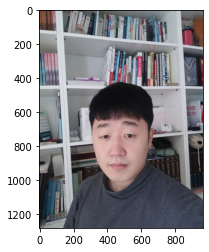

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  #cv2.imread는 bgr로 불러오므로 rgb형태로 변환 필요
plt.show()

In [3]:
# 저장할 파일 이름
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib 제공 모델 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0dde474640>)

In [4]:
#모델생성 및 지정
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
#이미지 입력
# PASCAL VOC 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
#사람라벨 15만을 검출하는 것이 필요

21

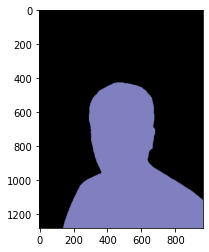

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
#어떤 물체가 담겨있는지 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
#사람에 해당하는 15번
colormap[15]

array([192, 128, 128])

In [12]:
#위에서 출력값은 bgr이므로 rgb형태로 변환필요
seg_color = (128,128,192)

(1280, 960)


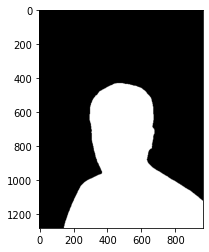

In [13]:
#seg_color로 이뤄진 마스크 제작
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

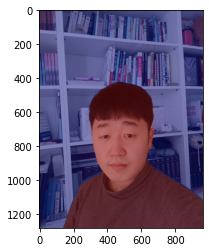

In [14]:
#겹쳐서 확인
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0로 변형
img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 병합
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

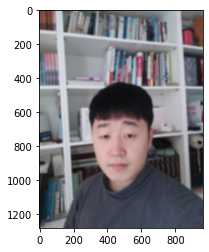

In [15]:
#사진전체흐리게
# (13,13)은 blurring kernel size - 변형가능
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

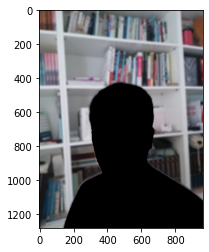

In [16]:
#배경추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

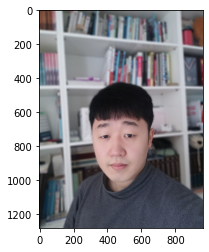

In [17]:
#이미지 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점
- 이미지와 사람 사이에 괴리가 있다.
- 확대해서 보면 제대로 구분되지 않은 부분이 보인다

# 고양이 사진 흐리기

(386, 580, 3)


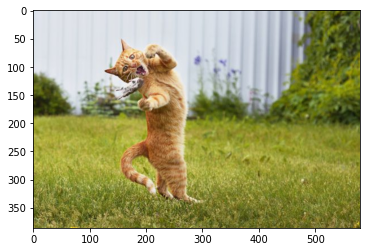

In [46]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cattt2.png'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
segvalues2, output2 = model2.segmentAsPascalvoc(img_path2)

(386, 580)


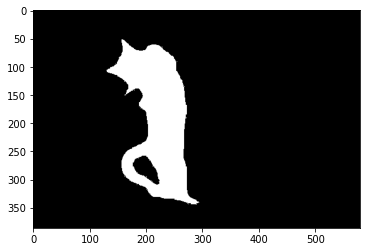

In [50]:
#seg_color로 이뤄진 마스크 제작
seg_map2 = np.all(output2==seg_color2, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

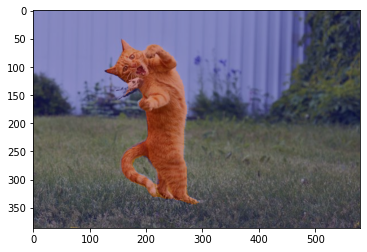

In [54]:
img_show2 = img_orig2.copy()

img_mask2 = seg_map2.astype(np.uint8) * 255

color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

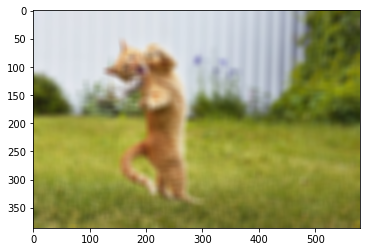

In [55]:
img_orig_blur2 = cv2.blur(img_orig2, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

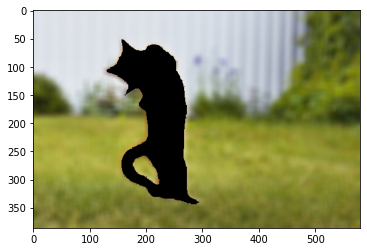

In [56]:
#배경추출
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

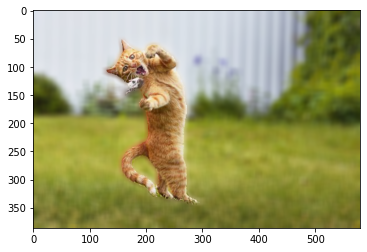

In [58]:
#이미지 합치기
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

# 배경전환 크로마키

(405, 600, 3)


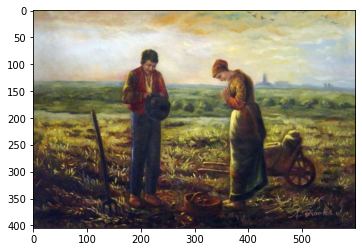

In [60]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/isac.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

(386, 580, 3)


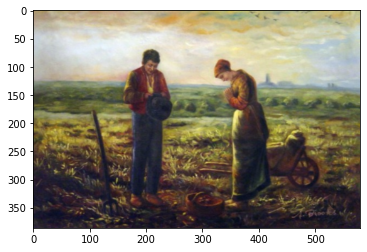

In [76]:
#리사이징
img_orig3 = cv2.resize(img_orig3, (580, 386))
print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

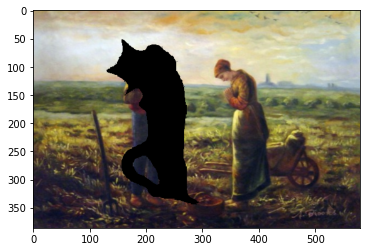

In [77]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig3, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

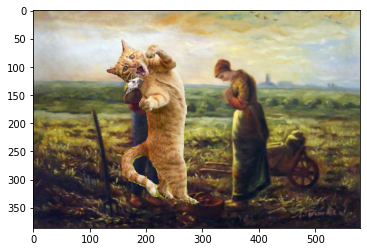

In [81]:
#이미지 합치기
img_concat3 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

# 해결방안
고양이를 출력한 이미지를 봤을 때 고양이 뿐만이 아닌 입 근처에 생선으로 추정되는 물체가 잘리지 않고 그대로 가져와졌습니다. 고양이 부분과 겹치는 곳이 있어서 같이 가져온 것으로 추정되는데, 이미지를 구분선이 명확한 것을 가져오는 것이 필요해 보입니다.
아니라면 모델이 구분하기 쉽도록 높은 화질의 이미지를 가져오는 것이 좋을 것 같습니다.

# 회고
이미지를 여러 장을 사용하다보니 변수명을 잘못 설정하여서 이리저리 헤맸습니다.
이를 고치기 위해서 변수명 설정을 조금 더 신중히 해야할 필요성을 느꼈습니다.